In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
import joblib
%matplotlib inline

np.random.seed(3)
tf.random.set_seed(3)

In [2]:
pre = pd.read_csv('kd_data_1226.csv')

pre_df = pd.DataFrame(pre)

pre_df

p_list = pre_df['person_id']

## class_weight

In [3]:
from sklearn.utils import class_weight

## Split

In [4]:
from sklearn.model_selection import train_test_split

## Stacking Ensemble

In [5]:
from sklearn import metrics

In [6]:
from tensorflow.keras.layers import Input,Dense,SimpleRNN, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L1, L2,L1L2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, RMSprop

In [7]:
METRICS = [ 
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import  cross_val_score, cross_val_predict  # 하이퍼파라미터 튜닝, 교차타당도

## Application - KD

In [10]:
from tensorflow.keras.optimizers import RMSprop,Adam

In [11]:
pre_df.columns = ['person_id', 'gender', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5',
       'age_6', 'age_7', 'age_8', 'smoking_status_0.0', 'smoking_status_1.0',
       'smoking_status_2.0', 'smoking_status_3.0', 'bmi_1.0', 'bmi_2.0', 'bmi_3.0',
       'bmi_4.0', 'Malignant_neoplastic_disease', 'Chronic_liver_disease',
       'chronic_obstructive_lung_disease', 'cerebrovascular_disease',
       'chronic_kidney_disease', 'Diabetes_mellitus', 'Ischemic_heart_disease',
       'hyperlipidemia', 'Hypertensive_disorder', 'cancer'] 

pre_df = pre_df.astype('int64')

In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('cancer')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)

    return ds

# layer와 feature를 나누고 섞고(shuffle), batch_size로 생성하는 과정

In [13]:
train, test = train_test_split(pre_df, test_size=0.3, random_state=3)
train_ds= df_to_dataset(train, batch_size=len(train),shuffle=False)
test_ds= df_to_dataset(test, batch_size=len(test),shuffle=False)

In [14]:
all_ds = df_to_dataset(pre_df, batch_size=len(pre_df),shuffle=False)

In [15]:
print(Counter(pre_df['cancer']))

Counter({0: 320, 1: 89})


In [16]:
from tensorflow.keras.utils import to_categorical

In [17]:
Y_cate = to_categorical(pre_df['cancer'])
X_data = pre_df.iloc[:,1:27]

In [18]:
X_data

,gender,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,smoking_status_0.0,...,bmi_4.0,Malignant_neoplastic_disease,Chronic_liver_disease,chronic_obstructive_lung_disease,cerebrovascular_disease,chronic_kidney_disease,Diabetes_mellitus,Ischemic_heart_disease,hyperlipidemia,Hypertensive_disorder
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
405,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
406,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
407,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_cate, test_size=0.3, random_state=3)

In [20]:
training, testing = train_test_split(pre_df['cancer'], test_size=0.3, random_state=3)

In [21]:
# test

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',np.unique(pre_df['cancer']),pre_df['cancer'])

class_weights 

C:\ProgramData\Anaconda32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=0      1
1      1
2      1
3      1
4      1
      ..
404    0
405    0
406    0
407    0
408    0
Name: cancer, Length: 409, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([0.6390625 , 2.29775281])

In [22]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [23]:
clf_labels = ['SVM','Random Forest']

pred = []

for label in clf_labels:
    model = joblib.load(label+'.pkl') # 저장한 모델 불러오기
    model = model.fit(X_train,training)
    Y_pred = model.predict(X_test)
    Y_pred = [ 1 if x >= 0.5 else 0 for x in Y_pred]
    print(classification_report(testing,Y_pred))
    fpr, tpr, thresholds =roc_curve(testing, model.predict_proba(X_test)[:,1])
    print(auc(fpr, tpr))
    real_pred = model.predict(X_data)
    real_pred = [ 1 if x >= 0.5 else 0 for x in real_pred]
    pred.append(real_pred)

              precision    recall  f1-score   support

           0       0.94      0.68      0.79        95
           1       0.44      0.86      0.59        28

    accuracy                           0.72       123
   macro avg       0.69      0.77      0.69       123
weighted avg       0.83      0.72      0.75       123

0.7477443609022557
              precision    recall  f1-score   support

           0       0.94      0.66      0.78        95
           1       0.43      0.86      0.57        28

    accuracy                           0.71       123
   macro avg       0.68      0.76      0.67       123
weighted avg       0.82      0.71      0.73       123

0.875187969924812


In [24]:
[(_, train_label)] = train_ds.take(1)
[(_, test_label)] = test_ds.take(1)

In [25]:
[(_, all_label)] = all_ds.take(1)

In [26]:
gbd_model = tf.keras.models.load_model('gbd_0108')

In [27]:
class_weights = {0:class_weights[0], 1:class_weights[1]}

In [28]:
gbd_model.compile(optimizer=Adam(learning_rate=0.005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS) # 기존 건보단 모델에서 optimizer의 학습률을 조정해 새로 학습

In [29]:
history = gbd_model.fit(train_ds, epochs=100,callbacks=[early_stopping],class_weight = class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100


C:\Users\dladu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:588: UserWarning: Input dict contained keys ['person_id'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
C:\Users\dladu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


1/1 [==============================] - 6s 6s/step - loss: 8.0424 - tp: 34.0000 - fp: 125.0000 - tn: 100.0000 - fn: 27.0000 - accuracy: 0.4685 - precision: 0.2138 - recall: 0.5574 - auc: 0.5051 - prc: 0.2182
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 2.5004 - tp: 34.0000 - fp: 123.0000 - tn: 102.0000 - fn: 27.0000 - accuracy: 0.4755 - precision: 0.2166 - recall: 0.5574 - auc: 0.5557 - prc: 0.2662
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.7309 - tp: 48.0000 - fp: 138.0000 - tn: 87.0000 - fn: 13.0000 - accuracy: 0.4720 - precision: 0.2581 - recall: 0.7869 - auc: 0.6014 - prc: 0.2515
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6729 - tp: 41.0000 - fp: 125.0000 - tn: 100.0000 - fn: 20.0000 - accuracy: 0.4930 - precision: 0.2470 - recall: 0.6721 - auc: 0.5992 - prc: 0.2759
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.6808 - tp: 25.0000 - fp: 81.0000 - tn: 144.0000 - fn: 36.

In [30]:
D_pred = gbd_model.predict(test_ds)
D_pred = [ 1 if x >= 0.5 else 0 for x in D_pred]

print(confusion_matrix(test_label,D_pred,labels=[1,0]))
print(classification_report(test_label,D_pred))
results = gbd_model.evaluate(test_ds)
        
for name, value in zip(gbd_model.metrics_names, results):
    print(name, ': ', value)
       
real_pred = gbd_model.predict(all_ds)
real_pred = [ 1 if x >= 0.5 else 0 for x in real_pred]
pred.append(real_pred)

[[25  3]
 [25 70]]
              precision    recall  f1-score   support

           0       0.96      0.74      0.83        95
           1       0.50      0.89      0.64        28

    accuracy                           0.77       123
   macro avg       0.73      0.81      0.74       123
weighted avg       0.85      0.77      0.79       123



C:\Users\dladu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:588: UserWarning: Input dict contained keys ['person_id'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
C:\Users\dladu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


1/1 [==============================] - 3s 3s/step - loss: 0.4239 - tp: 25.0000 - fp: 25.0000 - tn: 70.0000 - fn: 3.0000 - accuracy: 0.7724 - precision: 0.5000 - recall: 0.8929 - auc: 0.8962 - prc: 0.7373
loss :  0.42386916279792786
tp :  25.0
fp :  25.0
tn :  70.0
fn :  3.0
accuracy :  0.772357702255249
precision :  0.5
recall :  0.8928571343421936
auc :  0.8962405920028687
prc :  0.737336277961731


In [31]:
kd_data = np.array(pred)
print(kd_data.shape)

kd_data = np.transpose(kd_data)
print(kd_data.shape)

(3, 409)
(409, 3)


## KD Ensemble model 생성

In [32]:
em_train, em_test = train_test_split(kd_data, test_size=0.3, random_state=3)

In [33]:
em_train_y , em_test_y = train_test_split(pre_df['cancer'], test_size=0.3, random_state=3)

In [34]:
print(em_train.shape)
print(em_train_y.shape)

(286, 3)
(286,)


In [35]:
em_train_y = np.array(em_train_y)

In [36]:
#, kernel_regularizer=l2(0.02)
model = Sequential()
model.add(Dense(32,activation="relu",  input_dim=3))
model.add(Dropout(0.01))
model.add(Dense(16,activation="relu", kernel_regularizer=L2(0.01)))
model.add(Dense(10,activation="relu", kernel_regularizer=L2(0.01)))
#model.add(Dropout(0.01))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer=RMSprop(learning_rate=0.005),loss='binary_crossentropy',metrics=METRICS)

In [37]:
history = model.fit(em_train, em_train_y,epochs=100,batch_size=64, validation_split = 0.2, 
                         verbose=2,callbacks=[early_stopping])#, class_weight = class_weights)

Epoch 1/100
4/4 - 5s - loss: 0.9819 - tp: 37.0000 - fp: 49.0000 - tn: 223.0000 - fn: 42.0000 - accuracy: 0.7407 - precision: 0.4302 - recall: 0.4684 - auc: 0.6272 - prc: 0.4472 - val_loss: 0.9094 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 48.0000 - val_fn: 10.0000 - val_accuracy: 0.8276 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7312 - val_prc: 0.4089
Epoch 2/100
4/4 - 0s - loss: 0.8880 - tp: 20.0000 - fp: 13.0000 - tn: 164.0000 - fn: 31.0000 - accuracy: 0.8070 - precision: 0.6061 - recall: 0.3922 - auc: 0.8352 - prc: 0.5924 - val_loss: 0.8435 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 48.0000 - val_fn: 10.0000 - val_accuracy: 0.8276 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7312 - val_prc: 0.4089
Epoch 3/100
4/4 - 0s - loss: 0.8314 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 177.0000 - fn: 51.0000 - accuracy: 0.7763 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7835 - prc: 0.4433 - val_loss: 0.7913 - val_tp: 0.0000e+

Epoch 23/100
4/4 - 0s - loss: 0.3486 - tp: 45.0000 - fp: 28.0000 - tn: 149.0000 - fn: 6.0000 - accuracy: 0.8509 - precision: 0.6164 - recall: 0.8824 - auc: 0.9031 - prc: 0.5805 - val_loss: 0.3601 - val_tp: 7.0000 - val_fp: 8.0000 - val_tn: 40.0000 - val_fn: 3.0000 - val_accuracy: 0.8103 - val_precision: 0.4667 - val_recall: 0.7000 - val_auc: 0.8781 - val_prc: 0.4634
Epoch 24/100
4/4 - 0s - loss: 0.3438 - tp: 44.0000 - fp: 28.0000 - tn: 149.0000 - fn: 7.0000 - accuracy: 0.8465 - precision: 0.6111 - recall: 0.8627 - auc: 0.8974 - prc: 0.5803 - val_loss: 0.3631 - val_tp: 7.0000 - val_fp: 8.0000 - val_tn: 40.0000 - val_fn: 3.0000 - val_accuracy: 0.8103 - val_precision: 0.4667 - val_recall: 0.7000 - val_auc: 0.8781 - val_prc: 0.4634
Epoch 25/100
4/4 - 0s - loss: 0.3392 - tp: 44.0000 - fp: 26.0000 - tn: 151.0000 - fn: 7.0000 - accuracy: 0.8553 - precision: 0.6286 - recall: 0.8627 - auc: 0.9074 - prc: 0.6307 - val_loss: 0.3634 - val_tp: 7.0000 - val_fp: 8.0000 - val_tn: 40.0000 - val_fn: 3.00

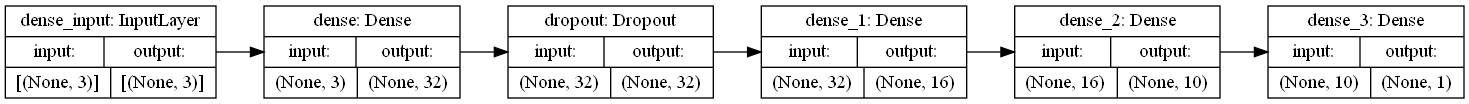

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR", to_file='./kd_model.png')

In [39]:
en_pred = model.predict(em_test)

In [40]:
#en_pred

In [41]:
en_pred = [ 1 if x[0] >= 0.5 else 0 for x in en_pred]

In [42]:
confusion_matrix(em_test_y,en_pred,labels=[1,0])

array([[23,  5],
       [19, 76]], dtype=int64)

In [43]:
print(classification_report(em_test_y,en_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86        95
           1       0.55      0.82      0.66        28

    accuracy                           0.80       123
   macro avg       0.74      0.81      0.76       123
weighted avg       0.85      0.80      0.82       123



In [44]:
fpr, tpr, thresholds = metrics.roc_curve(em_test_y, en_pred) #곡선 그리기
score = metrics.auc(fpr, tpr) #면적 구하기
print(score) #1.0

0.8107142857142858


In [45]:
#model.save('kd_ensemble')